In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
# Set path to project root (adjust if your notebook is deeper)
project_root = Path().resolve().parent
sys.path.append(str(project_root))
from src.models.baseline.svr import svr_pipeline  # adjust if needed

# Load data
data = pd.read_csv("../data/processed/merged_covid_data.csv")  # replace with your actual path

# Define config
config = {
    "countries": ["US"],
    "target_var": "new_cases",
    "exogenous_vars":[],
    #"exogenous_vars": ['new_deaths', 'new_recovered'],
    #"exogenous_vars": ["new_deaths", "new_recovered"] + [
    #    "retail_and_recreation_percent_change_from_baseline",
    #    "grocery_and_pharmacy_percent_change_from_baseline",
    #    "parks_percent_change_from_baseline",
    #    "transit_stations_percent_change_from_baseline",
    #    "workplaces_percent_change_from_baseline",
    #    "residential_percent_change_from_baseline"
    #],
    "input_window": 28,
    "forecast_steps": 14,
    "split_ratio": 0.8,
    #"scaler_config": {"type": "z_score"},
    "scaler_config": {
        "type": "min_max",
        "min_max_range": (0, 100)
        },
    "svr_params": {
        "kernel": "rbf",
        "cv": 3,
        "param_grid": {
            "C": [0.1, 1.0, 10.0],
            "gamma": ["scale", "auto"]
        }
    }
}

# Run pipeline
results, best_params_summary = svr_pipeline(data, config)
df_result = pd.DataFrame(results)
print('Best params selected are', best_params_summary)



Best params selected are {'step_0': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_1': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_2': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_3': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_4': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_5': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_6': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_7': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_8': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_9': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_10': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_11': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_12': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}, 'step_13': {'C': 1.0, 'gamma': 'scale', 'epsilon': 0.1}}


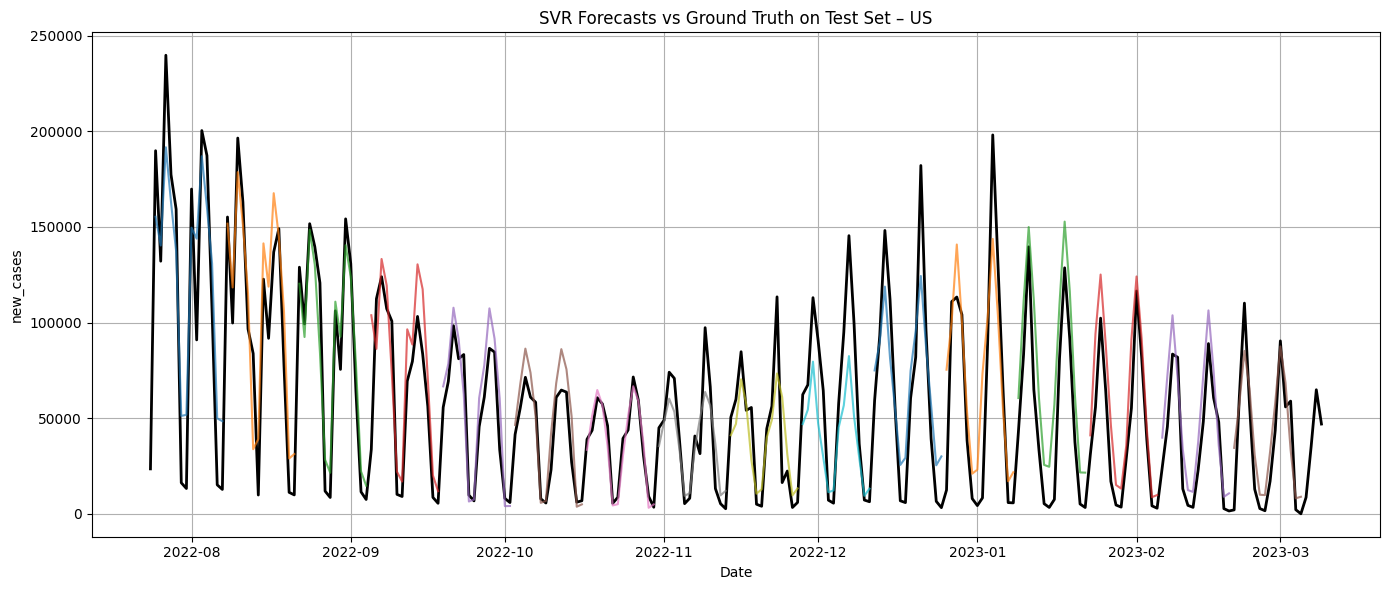

In [2]:
# Get the forecast steps and country
forecast_steps = config["forecast_steps"]
country = config["countries"][0]

# Get full series and restrict to test set only
df_country = data[data["country"] == country].copy()
df_country["date"] = pd.to_datetime(df_country["date"])
df_country = df_country.sort_values("date").reset_index(drop=True)

split_idx = int(len(df_country) * config["split_ratio"])
df_test = df_country.iloc[split_idx:].reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_test["date"], df_test[config["target_var"]], label="Ground Truth (Test Set)", color="black", linewidth=2)

# Plot forecasts: every `forecast_steps` index only
for i in range(0, len(df_result), forecast_steps):
    row = df_result.iloc[i]
    forecast_dates = pd.to_datetime(row["forecast_dates"])
    
    # Only plot forecasts that fall within the test date range
    if forecast_dates[0] >= df_test["date"].min() and forecast_dates[-1] <= df_test["date"].max():
        plt.plot(forecast_dates, row["predictions"], label=f"Forecast from {row['forecast_origin']}", alpha=0.7)

plt.title(f"SVR Forecasts vs Ground Truth on Test Set – {country}")
plt.xlabel("Date")
plt.ylabel(config["target_var"])
#plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import sys
from pathlib import Path
# Set path to project root (adjust if your notebook is deeper)
project_root = Path().resolve().parent
sys.path.append(str(project_root))

from src.models.baseline.lstm import lstm_pipeline  # adjust if needed

# Load sample data
df = pd.read_csv("../data/processed/merged_covid_data.csv", parse_dates=["date"])

# Define test config
config = {
    "countries": ["China"],
    "target_var": "new_cases",
    "exogenous_vars": [],
    "input_window": 14,
    "forecast_steps": 7,
    "split_ratio": 0.7,
    "scaler_config": {
        "type": "min_max",
        "min_max_range": (0, 1)
    },
    "lstm_param_grid": {
        "batch_size": [16, 32],
        "hidden_dim": [32, 64],
        "dropout": [0.2],
        "learning_rate": [0.001],
        "epochs": [50]
    }
}

# Run pipeline
df_result, best_params = lstm_pipeline(df, config)




c:\Users\guoya\miniconda3\envs\covidmodels\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


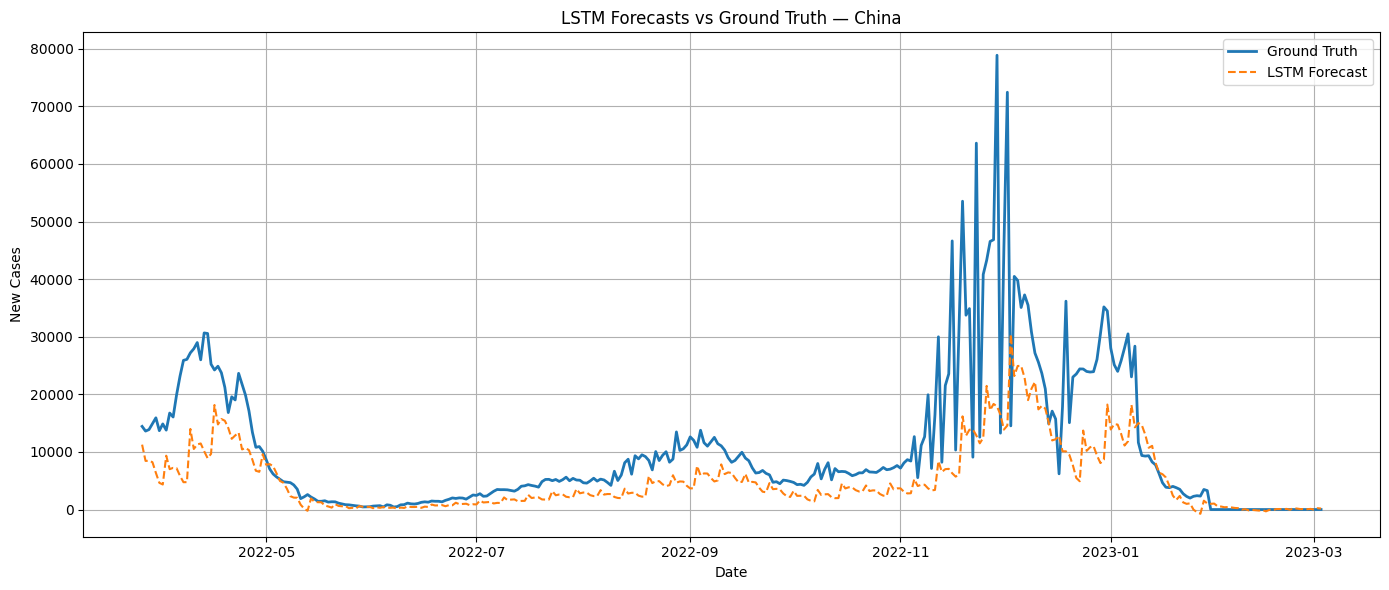

In [4]:


# Plotting the test set only (1st, 8th, 15th forecast...)
forecast_steps = config["forecast_steps"]
test_results = df_result[df_result["country"] == "China"].reset_index(drop=True)

plt.figure(figsize=(14, 6))
all_preds = []
all_trues = []
all_dates = []

for idx in range(0, len(test_results), forecast_steps):
    row = test_results.iloc[idx]
    all_preds.extend(row["predictions"])
    all_trues.extend(row["true_values"])
    all_dates.extend(pd.to_datetime(row["forecast_dates"]))

plt.plot(all_dates, all_trues, label="Ground Truth", linewidth=2)
plt.plot(all_dates, all_preds, label="LSTM Forecast", linestyle="--")
plt.title("LSTM Forecasts vs Ground Truth — China")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Set path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

from src.models.baseline.prophet import prophet_pipeline, generate_oxcgrt_holidays, generate_fixed_holidays

# Load dataset
data = pd.read_csv("../data/processed/merged_covid_data.csv", parse_dates=["date"])
country = "US"
forecast_steps = 14

# Holiday generation
oxcgrt_holidays = generate_oxcgrt_holidays(data)
calendar_holidays = generate_fixed_holidays(country)
combined_holidays = pd.concat([
    oxcgrt_holidays.get(country, pd.DataFrame()),
    calendar_holidays
])

# Define config
config = {
    "countries": [country],
    "target_var": "new_cases",
    "exogenous_vars": [],  # or include death/recovered or policy/mobility features
    "input_window": 28,     # dummy for compatibility
    "forecast_steps": forecast_steps,
    "split_ratio": 0.8,
    "holidays": {country: combined_holidays},
    "seasonalities": [
        {"name": "weekly", "period": 7, "fourier_order": 3},
        {"name": "monthly", "period": 30.5, "fourier_order": 5}
    ]
}




20:15:40 - cmdstanpy - INFO - Chain [1] start processing
20:15:40 - cmdstanpy - INFO - Chain [1] done processing
20:15:41 - cmdstanpy - INFO - Chain [1] start processing
20:15:41 - cmdstanpy - INFO - Chain [1] done processing
20:15:41 - cmdstanpy - INFO - Chain [1] start processing
20:15:41 - cmdstanpy - INFO - Chain [1] done processing
20:15:41 - cmdstanpy - INFO - Chain [1] start processing
20:15:41 - cmdstanpy - INFO - Chain [1] done processing
20:15:42 - cmdstanpy - INFO - Chain [1] start processing
20:15:42 - cmdstanpy - INFO - Chain [1] done processing
20:15:42 - cmdstanpy - INFO - Chain [1] start processing
20:15:42 - cmdstanpy - INFO - Chain [1] done processing
20:15:42 - cmdstanpy - INFO - Chain [1] start processing
20:15:42 - cmdstanpy - INFO - Chain [1] done processing
20:15:42 - cmdstanpy - INFO - Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1] done processing
20:15:43 - cmdstanpy - INFO - Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1]

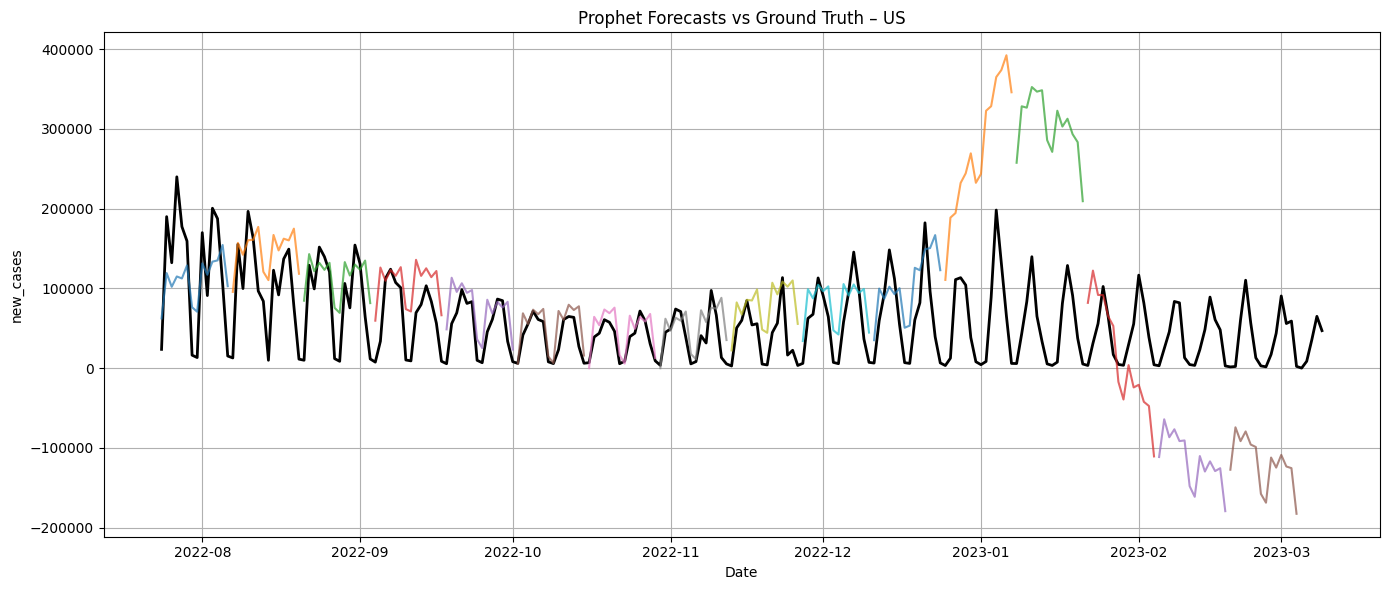

In [6]:
# Run Prophet pipeline
results_df = prophet_pipeline(data, config)

# Get test data
df_country = data[data["country"] == country].sort_values("date").reset_index(drop=True)
split_idx = int(len(df_country) * config["split_ratio"])
df_test = df_country.iloc[split_idx:].reset_index(drop=True)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_test["date"], df_test["new_cases"], label="Ground Truth (Test Set)", color="black", linewidth=2)

for i in range(0, len(results_df), forecast_steps):
    row = results_df.iloc[i]
    forecast_dates = pd.to_datetime(row["forecast_dates"])
    
    # Only show forecasts within test set
    if forecast_dates[0] >= df_test["date"].min() and forecast_dates[-1] <= df_test["date"].max():
        plt.plot(forecast_dates, row["predictions"], label=f"Forecast from {row['forecast_origin']}", alpha=0.7)

plt.title(f"Prophet Forecasts vs Ground Truth – {country}")
plt.xlabel("Date")
plt.ylabel("new_cases")
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\guoya\miniconda3\envs\covidmodels\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Best hyperparameters selected:
{'China': {'cnn': {'filters': 64, 'kernel_size': 2, 'activation': 'relu', 'pool_size': 2}, 'lstm': {'units': 64, 'activation': 'relu'}, 'training': {'epochs': 50, 'batch_size': 32, 'validation_split': 0.2, 'patience': 10}}}


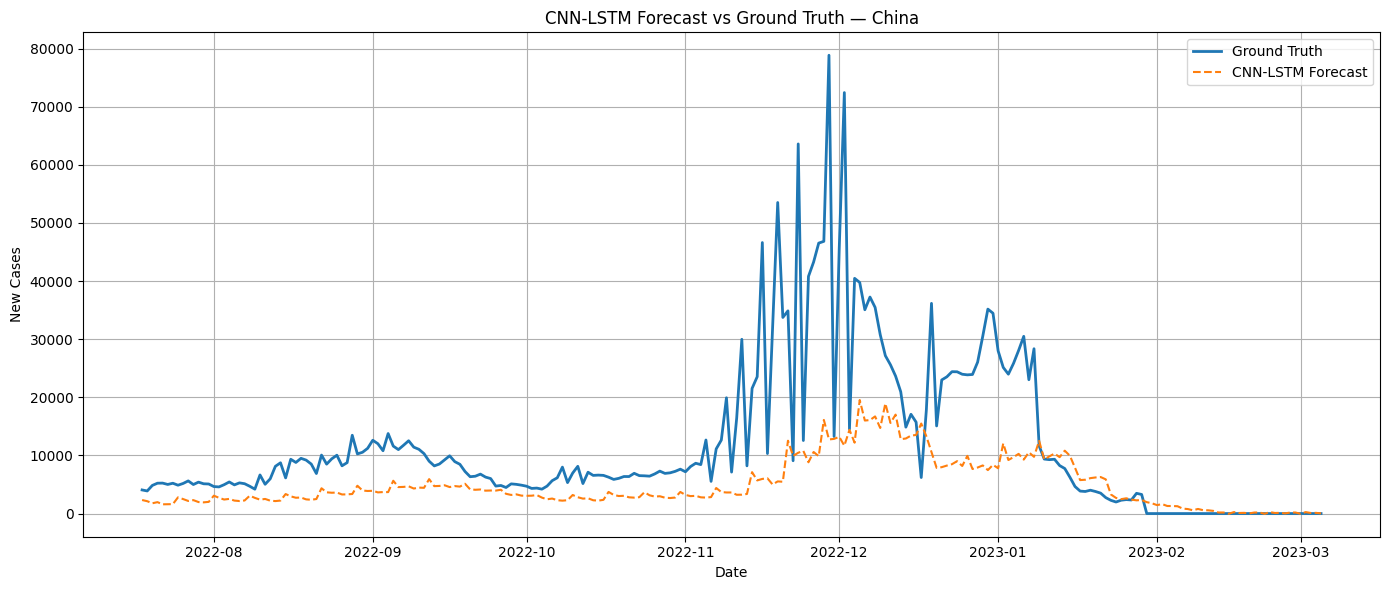

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Set path to project root (adjust if needed)
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Import the updated pipeline (with internal search)
from src.models.newly_proposed.cnn_lstm import cnn_lstm_pipeline  # Adjust if needed

# Load dataset
df = pd.read_csv("../data/processed/merged_covid_data.csv", parse_dates=["date"])

# Define config with grid (not fixed hyperparams)
config = {
    "countries": ["China"],
    "target_var": "new_cases",
    "exogenous_vars": [],
    "input_window": 14,
    "forecast_steps": 7,
    "split_ratio": 0.8,
    "scaler_config": {
        "type": "min_max",
        "min_max_range": (0, 1)
    },
    "cnn_param_grid": {
        "filters": [32, 64],
        "kernel_size": [2],
        "activation": ['relu'],
        "pool_size": [2]
    },
    "lstm_param_grid": {
        "units": [32, 64],
        "activation": ['relu']
    },
    "training_param_grid": {
        "epochs": [50],
        "batch_size": [32],
        "validation_split": [0.2],
        "patience": [10]
    }
}

# Run the updated pipeline
df_result, best_params = cnn_lstm_pipeline(df, config)

# Print best selected hyperparams
print("Best hyperparameters selected:")
print(best_params)

# Visualize predictions
forecast_steps = config["forecast_steps"]
test_results = df_result[df_result["country"] == "China"].reset_index(drop=True)

plt.figure(figsize=(14, 6))
all_preds, all_trues, all_dates = [], [], []

for idx in range(0, len(test_results), forecast_steps):
    row = test_results.iloc[idx]
    all_preds.extend(row["predictions"])
    all_trues.extend(row["true_values"])
    all_dates.extend(pd.to_datetime(row["forecast_dates"]))

plt.plot(all_dates, all_trues, label="Ground Truth", linewidth=2)
plt.plot(all_dates, all_preds, label="CNN-LSTM Forecast", linestyle="--")
plt.title("CNN-LSTM Forecast vs Ground Truth — China")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Set path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Import pipeline
from src.models.newly_proposed.curvefit_lstm import curvefit_lstm_pipeline

# Load data
df = pd.read_csv("../data/processed/merged_covid_data.csv", parse_dates=["date"], index_col=0)

# Define config
config = {
    "countries": ["China"],
    "target_var": "new_cases",
    "exogenous_vars": [],
    "input_window": 14,
    "forecast_steps": 7,
    "split_ratio": 0.7,
    "scaler_config": {
        "type": "min_max",
        "min_max_range": (0, 1)
    },
    "curvefit_params": {
        "model": "gaussian",
        "smoothing_window": 7
    },
    "lstm_params_grid": {
        "units": 50,
        "dropout": 0.2,
        "learning_rate": 0.001,
        "epochs": 50,
        "batch_size": 32
    }
}

# Run pipeline
try:
    df_result = curvefit_lstm_pipeline(df, config)
except Exception as e:
    print(f"❌ Error during pipeline run: {e}")
    raise





c:\Users\guoya\miniconda3\envs\covidmodels\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


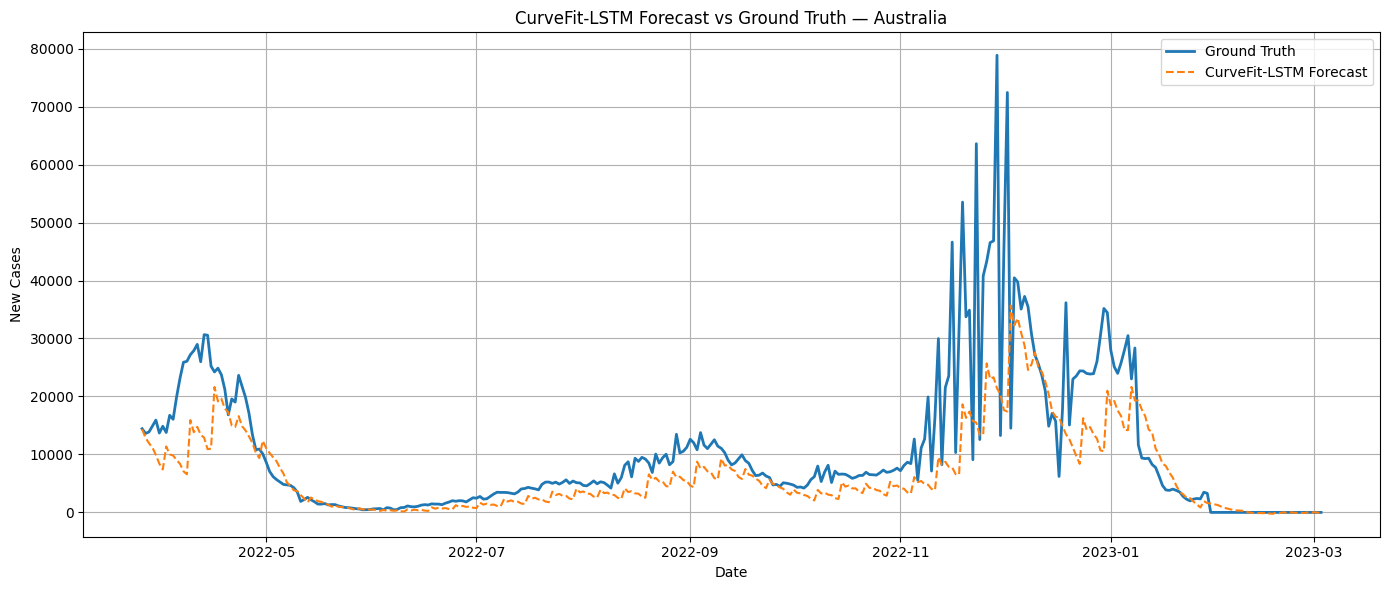

In [9]:
results, params = df_result

# Visualize
forecast_steps = config["forecast_steps"]
test_results = results[results["country"] == "China"].reset_index(drop=True)

plt.figure(figsize=(14, 6))
all_preds, all_trues, all_dates = [], [], []

for idx in range(0, len(test_results), forecast_steps):
    row = test_results.iloc[idx]
    all_preds.extend(row["predictions"])
    all_trues.extend(row["true_values"])
    all_dates.extend(pd.to_datetime(row["forecast_dates"]))

plt.plot(all_dates, all_trues, label="Ground Truth", linewidth=2)
plt.plot(all_dates, all_preds, label="CurveFit-LSTM Forecast", linestyle="--")
plt.title("CurveFit-LSTM Forecast vs Ground Truth — Australia")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

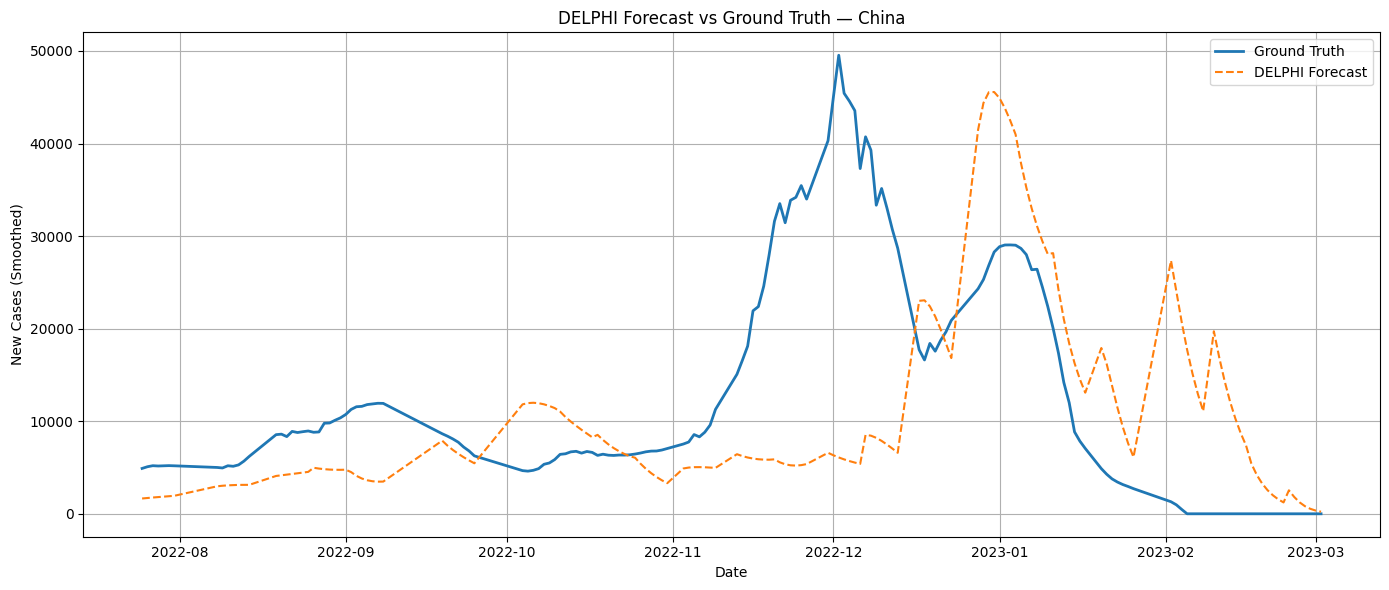

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Set path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Import pipeline
from src.models.newly_proposed.delphi import fit_and_forecast

# Define config
config = {
    "file_path": "../data/processed/merged_covid_data.csv",
    "population_path": "../data/processed/population_global.csv",
    "countries": ["China"],
    "n_days_fit": 30,
    "n_days_forecast": 7,
    "split_ratio": 0.8,
    "p0": [0.2, 0.5, 0.1, 0.01, 0.5, 0.1, 15],  # Optional: initial guess
    "bounds": [  # Optional: parameter bounds
        (0.01, 1.0),
        (0.01, 2.0),
        (0.01, 1.0),
        (0.001, 0.1),
        (0.0, 1.0),
        (0.01, 1.0),
        (0, 100)
    ]
}

# Run pipeline
try:
    df_result = fit_and_forecast(config)
except Exception as e:
    print(f"❌ Error during pipeline run: {e}")
    raise

# Visualize
forecast_steps = config["n_days_forecast"]
test_results = df_result[df_result["country"] == "China"].reset_index(drop=True)

plt.figure(figsize=(14, 6))
all_preds, all_trues, all_dates = [], [], []

for idx in range(0, len(test_results), forecast_steps):
    row = test_results.iloc[idx]
    all_preds.extend(row["predictions"])
    all_trues.extend(row["true_values"])
    all_dates.extend(pd.to_datetime(row["forecast_dates"]))

plt.plot(all_dates, all_trues, label="Ground Truth", linewidth=2)
plt.plot(all_dates, all_preds, label="DELPHI Forecast", linestyle="--")
plt.title("DELPHI Forecast vs Ground Truth — China")
plt.xlabel("Date")
plt.ylabel("New Cases (Smoothed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


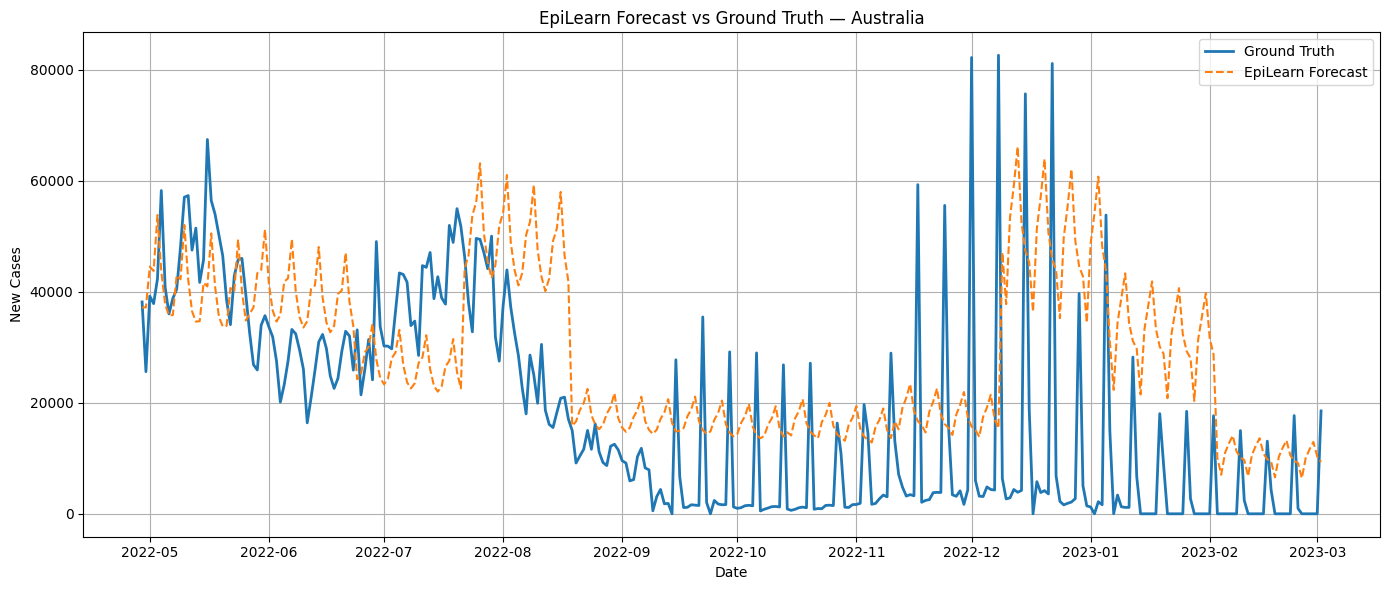

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Set path to project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Import pipeline
from src.models.newly_proposed.epilearn import epilearn_pipeline

# Load dataset
df = pd.read_csv("../data/processed/merged_covid_data.csv", parse_dates=["date"], index_col=0)

# Create dictionary {country: DataFrame} expected by epilearn
data_dict = {
    country: df[df["country"] == country].copy().set_index("date")
    for country in df["country"].unique()
}

# Define config
config = {
    "country": "Australia",
    "target_var": "new_cases",
    "match_length": 28,
    "forecast_length": 28,
    "forecast_type": "median",       # Options: 'mean', 'median', 'weightedmedian'
    "smoothing_sigma": 2.0,
    "lambda_": 108.0,
    "mu": 0.0675,
    "split_ratio": 0.7
}

# Run pipeline
try:
    df_result = epilearn_pipeline(config, data_dict)
except Exception as e:
    print(f"❌ Error during pipeline run: {e}")
    raise

# ✅ Visualization
forecast_steps = config["forecast_length"]
test_results = df_result[df_result["country"] == config["country"]].reset_index(drop=True)

plt.figure(figsize=(14, 6))
all_preds, all_trues, all_dates = [], [], []

for idx in range(0, len(test_results), forecast_steps):
    row = test_results.iloc[idx]
    all_preds.extend(row["predictions"])
    all_trues.extend(row["true_values"])
    all_dates.extend(pd.to_datetime(row["forecast_dates"]))

plt.plot(all_dates, all_trues, label="Ground Truth", linewidth=2)
plt.plot(all_dates, all_preds, label="EpiLearn Forecast", linestyle="--")
plt.title(f"EpiLearn Forecast vs Ground Truth — {config['country']}")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
